In [1]:
import torch
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import mlflow.pytorch
import nannyml as nml

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/cpu_data_custom_orangepi.csv')

# Convert string representation of lists back to actual lists
df['features'] = df['features'].apply(ast.literal_eval)
df.reset_index(drop=True, inplace=True)

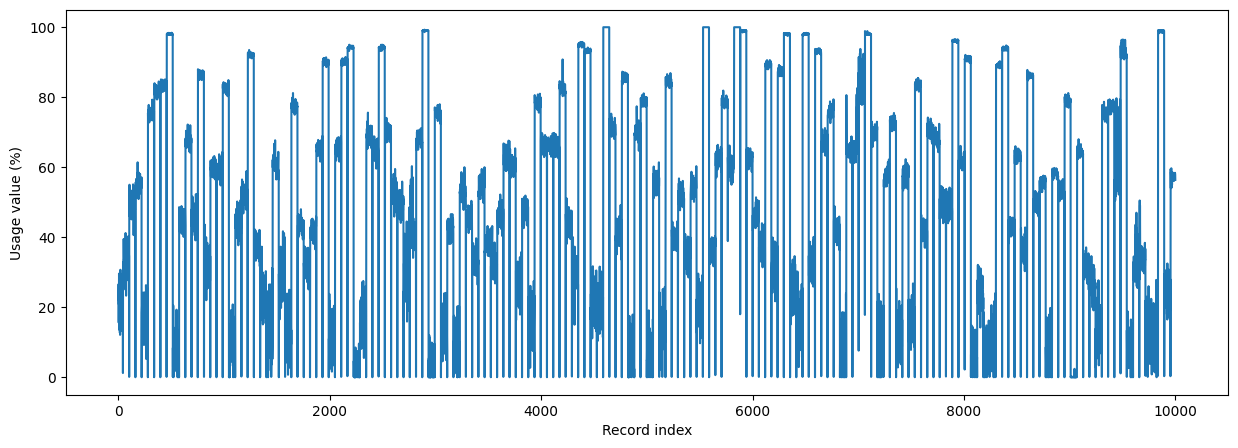

In [3]:
plt.figure(figsize=(15,5))
plt.plot(df.index[:10000], df['target'][:10000])
plt.xlabel('Record index')
plt.ylabel('Usage value (%)')
# plt.title('CPU Usage (%)')
plt.show()

In [4]:
train_data = df[0:70000]
test_data = df[70000:85000]
prod_data = df[85000:]

In [5]:
X_test=test_data[['features']]
y_test=test_data['target']
X_prod=prod_data[['features']]
y_prod=prod_data['target']

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        output = self.fc(lstm_out.view(len(input), -1))
        return output[-1]

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        x = torch.tensor(sample['features'], dtype=torch.float32)
        y = torch.tensor(sample['target'], dtype=torch.float32)
        return x, y

In [8]:
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')
    print('========Training Completed========')

In [9]:
input_size = 8  # Input size is the length of the input list
hidden_size = 16
output_size = 1
learning_rate = 0.001
epochs = 10

In [10]:
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
train_dataset = CustomDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# Train the model for task 1
train_model(model, train_dataloader, criterion, optimizer, epochs)

========Training Completed========


In [12]:
def predict_model(dataloader):
    test_running_loss = 0.0
    test_total_samples = 0
    test_absolute_errors = 0.0
    predicted_values = []
    actual_values=[]
    
    # Switch model to evaluation mode
    model.eval()
    
    with torch.no_grad():  # No need to compute gradients during testing
        for data in dataloader:
            inputs, labels = data
            
            # Forward pass
            outputs = model(inputs)
            predicted_values.append(outputs)
            actual_values.append(labels)
    
            # Calculate loss (MSE or MAE)
            test_loss = criterion(outputs, labels)
            test_running_loss += test_loss.item()
            
            # Calculate absolute error (MAE)
            test_absolute_error = torch.abs(outputs - labels)
            test_absolute_errors += test_absolute_error.sum().item()
            
            # Update total samples
            test_total_samples += labels.size(0)
    
    # Calculate Mean Absolute Error (MAE) on test dataset
    test_mean_absolute_error = test_absolute_errors / test_total_samples
    
    # Print loss and MAE on test dataset
    # print(f'Test Loss: {test_running_loss/len(test_dataloader)}, Test MAE: {test_mean_absolute_error}')
    
    predicted_list = [round(output.item(),3) for output in predicted_values]
    actual_list = [round(output.item(),3) for output in actual_values]
    
    return np.array(actual_list), np.array(predicted_list)

In [13]:
train_dataset = CustomDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

test_dataset = CustomDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

y_train, y_pred_train=predict_model(train_dataloader)
y_test, y_pred_test=predict_model(test_dataloader)

In [14]:
# Make baseline predictions
y_pred_train_baseline = np.ones_like(y_train) * y_train.mean()
y_pred_test_baseline = np.ones_like(y_test) * y_train.mean()

# Measure train, test and baseline performance
mae_train = mean_absolute_error(y_train, y_pred_train).round(4)
mae_test = mean_absolute_error(y_test, y_pred_test).round(4)

mae_train_baseline = mean_absolute_error(y_train, y_pred_train_baseline).round(4)
mae_test_baseline = mean_absolute_error(y_test, y_pred_test_baseline).round(4)

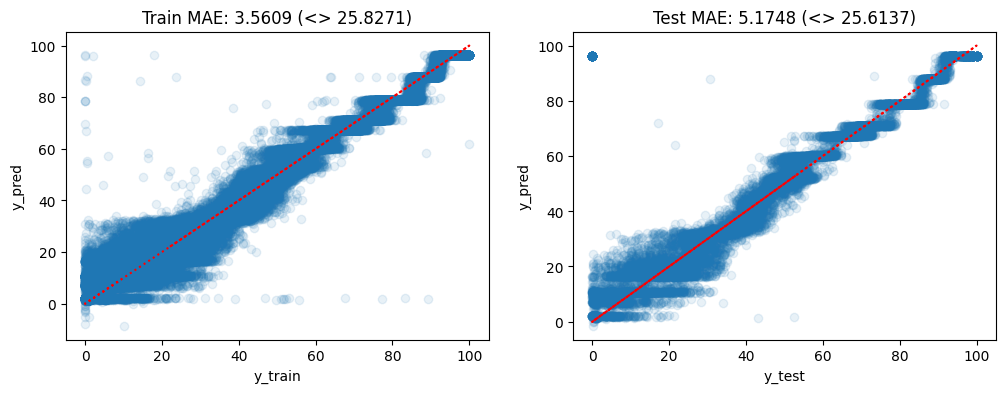

In [15]:
# Create performance report
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

title1 = 'Train MAE: {} (<> {})'.format(mae_train, mae_train_baseline)
ax1.set(title=title1, xlabel='y_train', ylabel='y_pred')
ax1.plot(y_train, y_train, color='red', linestyle=':')
ax1.scatter(y_train, y_pred_train, alpha=0.1)

title2 = 'Test MAE: {} (<> {})'.format(mae_test, mae_test_baseline)
ax2.set(title=title2, xlabel='y_test', ylabel='y_pred')
ax2.plot(y_test, y_test, color='red', linestyle=':')
ax2.scatter(y_test, y_pred_test, alpha=0.1)

plt.show()

In [16]:
def prod_predict_model(dataloader):
    predicted_values = []
    
    # Switch model to evaluation mode
    model.eval()
    
    with torch.no_grad():  # No need to compute gradients during testing
        for data in dataloader:
            inputs, labels = data
            
            # Forward pass
            outputs = model(inputs)
            predicted_values.append(outputs)
    predicted_list = [round(output.item(),3) for output in predicted_values]
    
    return np.array(predicted_list)

In [17]:
prod_dataset = CustomDataset(prod_data)
prod_dataloader = DataLoader(prod_dataset, batch_size=1, shuffle=False)

y_pred_prod =prod_predict_model(prod_dataloader)

In [18]:
reference_df = X_test.copy() # using the test set as a reference
reference_df['y_pred'] = y_pred_test # reference predictions
reference_df['y_true'] = y_test # ground truth (currect targets)

analysis_df = X_prod.copy() # features
analysis_df['y_pred'] = y_pred_prod # prod predictions

In [19]:
# Creating features from the list
values = reference_df['features'].iloc[0]
for i, value in enumerate(values[::1], start=1):
    reference_df[f'lag_{9-i}'] = value
reference_df.drop(columns=['features'], inplace=True)

In [20]:
# Creating features from the list
values = analysis_df['features'].iloc[0]
for i, value in enumerate(values[::1], start=1):
    analysis_df[f'lag_{9-i}'] = value
analysis_df.drop(columns=['features'], inplace=True)

In [21]:
features=['lag_8', 'lag_7', 'lag_6','lag_5','lag_4', 'lag_3', 'lag_2', 'lag_1']
dle = nml.DLE(
    metrics=['mae'],
    y_true='y_true',
    y_pred='y_pred',
    feature_column_names=features, chunk_size=150)

dle.fit(reference_df) # fit on the reference (test) data
estimated_performance = dle.estimate(analysis_df) # estimate on the prod data

In [22]:
figure = estimated_performance.plot()

In [23]:
figure

In [24]:
perfc = nml.PerformanceCalculator(metrics=['mae'],
                                  y_true='y_true',
                                  y_pred='y_pred',
                                  problem_type='regression',
                                  chunk_size=150)

perfc.fit(reference_df)
realized_performance = perfc.calculate(analysis_df.assign(y_true = y_prod))
figure = estimated_performance.filter(period='analysis').compare(realized_performance).plot()

In [25]:
figure